In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import cvxpy as cp  #pip install cvxpy --upgrade
import os
from scipy.optimize import minimize, LinearConstraint
from numpy.linalg import inv

os.chdir('D:/OneDrive/31_Portfolio optim')

In [2]:
equity = pd.read_excel("DataMonthly.xlsx", sheet_name = "Equity", index_col="Total Return Index USD")
equity = equity.dropna().iloc[:,0:6]
equity

,Australia,Canada,Italy,Japan,UK,US
Total Return Index USD,,,,,,
1999-01-29,1901.873734,1149.017445,5270.005824,4.082912,30213.955450,3060.452
1999-02-26,1865.546660,1086.912088,5171.886036,4.009209,30920.275767,2954.292
1999-03-31,1960.860184,1136.963580,5362.472088,4.565440,32019.642327,3071.671
1999-04-30,2138.698082,1252.958619,5253.630848,4.797502,33471.974183,3192.459
1999-05-31,1961.618069,1216.024955,5016.655888,4.555307,31850.431116,3126.752
...,...,...,...,...,...,...
2020-10-30,10160.181643,5651.331645,8026.276709,9.615078,57571.622773,12652.840
2020-11-30,11727.542487,6445.294551,10025.315191,10.698941,66987.935194,14168.150
2020-12-31,12492.224267,6684.041543,10402.021811,11.142747,71477.470258,14766.190


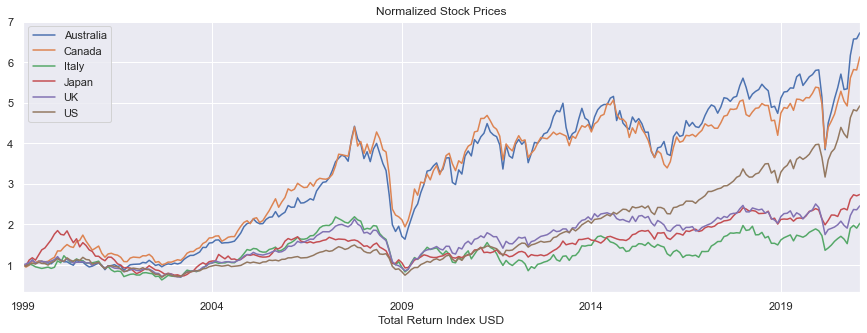

In [3]:
(equity / equity.iloc[0,:]) .plot(title="Normalized Stock Prices",figsize=(15,5))
plt.show()

we can see that equity index in different countries have quite the similar trend during the period

In [4]:
ret_equity = ((equity-equity.shift(1))/equity.shift(1)).dropna()
stock_namelist = equity.columns
ret_equity

,Australia,Canada,Italy,Japan,UK,US
Total Return Index USD,,,,,,
1999-02-26,-0.019101,-0.054051,-0.018619,-0.018052,0.023377,-0.034688
1999-03-31,0.051091,0.046049,0.036850,0.138738,0.035555,0.039732
1999-04-30,0.090694,0.102022,-0.020297,0.050830,0.045358,0.039323
1999-05-31,-0.082798,-0.029477,-0.045107,-0.050484,-0.048445,-0.020582
1999-06-30,0.061342,0.029853,-0.020222,0.112695,0.004125,0.043208
...,...,...,...,...,...,...
2020-10-30,0.003486,-0.023677,-0.069272,-0.015337,-0.034665,-0.023667
2020-11-30,0.154265,0.140491,0.249062,0.112725,0.163558,0.119760
2020-12-31,0.065204,0.037042,0.037576,0.041481,0.067020,0.042210


In [5]:
total_ret = equity.iloc[-1,:]/equity.iloc[0,:]
avg_ret = ret_equity.mean()
vol = ret_equity.std()
compare = pd.DataFrame([total_ret,avg_ret, vol]).T
compare.columns= ["total return","average return","volatility"]
compare

,total return,average return,volatility
Australia,6.721491,0.009239,0.062823
Canada,6.127297,0.008500,0.056641
Italy,2.024265,0.004903,0.066673
Japan,2.736066,0.004926,0.047421
UK,2.456700,0.004658,0.049923
US,4.920878,0.006964,0.043026


### Analysis:
Australia have the highest average return, highest average return and 2nd highest volatility.\
Canada has 2nd highest return.\
US has lowest volatility and not so bad return.

=> It is intuitively foresee that the portfolio allocation will focus on Australia, Canada and US.

# Part I: Global asset allocation with no currency hedging

In [6]:
# train test split 100 first samples
T_trn = 100  
ret_mat = np.ascontiguousarray(ret_equity.iloc[1::,:])
equity_trn = ret_mat[:T_trn,]
equity_tst = ret_mat[T_trn:,]

In [7]:
# We import the bond yield as the assumed risk free rate to calculate the excess return
# We notice the bond yield is %p.a therefore we have to divide to 12 and 100.
bond = pd.read_excel("DataMonthly.xlsx", sheet_name = "T-Bill",index_col = 0)
bond = bond.iloc[3:,:]/100/12
bond.columns = ['1M-T-Bill']
bond

,1M-T-Bill
1999-02-26,0.003917
1999-03-31,0.003750
1999-04-30,0.003792
1999-05-31,0.003883
1999-06-30,0.003983
...,...
2020-10-30,0.000067
2020-11-30,0.000067
2020-12-31,0.000067
2021-01-29,0.000058


In [8]:
# We assume the expected risk free rate is the average rfr of the train dataset
rfr = float(bond.iloc[:T_trn,].mean())
print('average risk free rate is: ', round(rfr*100,5) , ' % per month')

average risk free rate is:  0.27685  % per month


In [9]:
#calculate the average excess return
mu_trn = np.mean(equity_trn, axis=0) - rfr
Sigma_trn = np.cov(equity_trn.T)

### 1a. Equally weighted portfolio

In [10]:
w_EWP = np.ones(ret_equity.shape[1])/ret_equity.shape[1]
w_EWP

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

### 1b. Minimum variance portfolio:
As investors are assumed risk-averse but still want to make a good profit, we introduce the global minimum variance portfolio and the minimum variance portfolio with shortselling contraints

In [11]:
# Global minimum variance portfolio:
def GMVP(Sigma):
    ones = np.ones(Sigma.shape[0])
    Sigma_inv_1 = np.linalg.solve(Sigma, ones) # same as Sigma_inv @ ones
    w = Sigma_inv_1 / (np.sum(Sigma_inv_1))
    return w
w_GMVP = GMVP(Sigma_trn)

In [12]:
def MVP(mu, Sigma, cons ,w_EWP):
    w = cp.Variable(len(mu))
    variance = cp.quad_form(w, Sigma)
    expected_return = w @ mu
    if cons == "no short sell":
        constraint = [w @ mu >= w_EWP @ mu, w >= 0, cp.sum(w) == 1]
    if cons == "short sell":    
        constraint = [w @ mu >= w_EWP @ mu,cp.sum(w) == 1]
    problem = cp.Problem(cp.Minimize(variance), constraint)   
    problem.solve()         
    return w.value
w_MVP_short = MVP(mu_trn, Sigma_trn,"short sell",w_EWP)

### 1c. Maximum sharpe ratio portfolio:

In [13]:
def MSR(mu, Sigma):
    ones = np.ones(Sigma.shape[0])
    Sigma_inv_1 = np.linalg.solve(Sigma, mu) # same as Sigma_inv @ ones
    w = Sigma_inv_1 / (np.sum(Sigma_inv_1  ))
    return w
w_MSR = MSR(mu_trn, Sigma_trn)

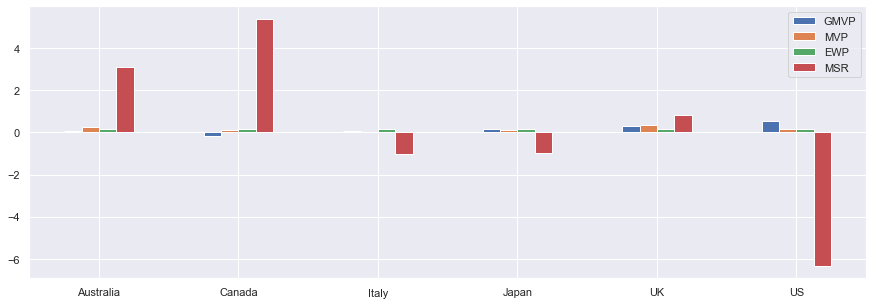

In [14]:
allocation = pd.DataFrame([w_GMVP,w_MVP_short,w_EWP,w_MSR],columns = stock_namelist)
allocation.index = ['GMVP','MVP','EWP','MSR']
allocation.T.plot.bar(figsize = (15,5))
plt.xticks(rotation=0)
plt.show()

In [15]:
allocation

,Australia,Canada,Italy,Japan,UK,US
GMVP,0.067040,-0.180212,0.079821,0.180208,0.303033,0.550110
MVP,0.234083,0.128536,0.019983,0.117383,0.331347,0.168667
EWP,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
MSR,3.083581,5.395301,-1.000764,-0.954305,0.814349,-6.338162


### Comment:
As expected, the allocation of max sharpe ratio portfolio, which is in the mean-variance framework, focuses on equities with highest return (Australia, Canada) or lowest volatility (US). It can be seen that this portfolio go long on the high return assets and go short the low volatility assets.
The equally weighted portfolio keep equal asset allocations
The Global minimum variance portfolio go long the most on US stock to minimize the variance.This portfolio is expected to have low return also.
In this exercise, we try to introduce also the Minimum variance portfolio with no short selling constraint and keep higher return than Equally weighted portfolio. We see that it differs from EWP weights. It also focus on Australia equity. 

We will see the performance of these porfolio in the next part

### 2+3. Calculate the in-sample (2/1999-05/2007) and out-of-sample

In [16]:
def performance(ret_equity,allocation):
    ret = []
    vol = []
    sharpe = []
    wealth = []
    for i in range(4):
        ret.append((np.array(ret_equity) @ (allocation.iloc[i,:].T)).mean()-rfr)
        vol.append(np.sqrt(np.dot(allocation.iloc[i,:],np.dot(ret_equity.cov(),allocation.iloc[i,:].T))))
        sharpe.append(ret[i]/vol[i])
    performance = pd.DataFrame([ret,vol,sharpe],columns = allocation.index).T
    return performance

performance  = pd.concat([performance(ret_equity.iloc[:T_trn,],allocation),
                         performance(ret_equity.iloc[T_trn:,],allocation)], axis = 1)
performance.columns = ['avg excess return train','volatility train','sharpe ratio train',
                       'avg excess return test','volatility test','sharpe ratio test']
performance

,avg excess return train,volatility train,sharpe ratio train,avg excess return test,volatility test,sharpe ratio test
GMVP,0.002230,0.036055,0.061843,0.003211,0.046366,0.069252
MVP,0.006622,0.038084,0.173892,0.002219,0.052593,0.042192
EWP,0.006596,0.038659,0.170609,0.002046,0.052575,0.038923
MSR,0.081555,0.221741,0.367794,-0.014702,0.280291,-0.052453


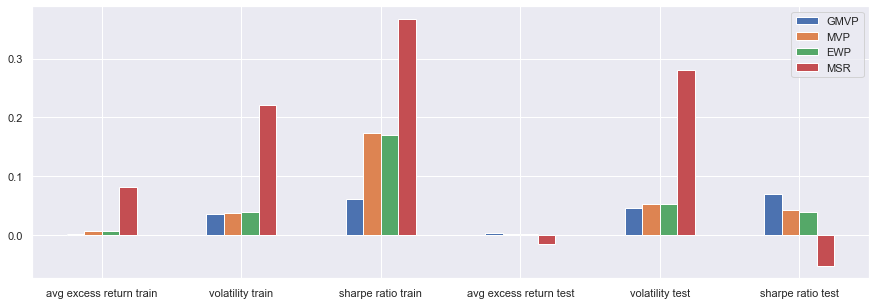

In [17]:
performance.T.plot.bar(figsize = (15,5))
plt.xticks(rotation=0)
plt.show()

compute cumulative wealth

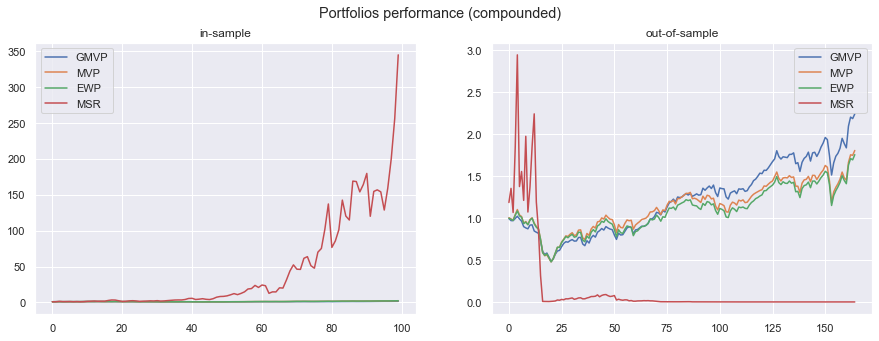

<Figure size 720x1080 with 0 Axes>

In [18]:
wealth_geom_trn = []
wealth_geom_tst = []
for i in range(4):
    wealth_geom_trn.append(np.cumprod(np.array(ret_equity.iloc[:T_trn,]) @ (allocation.iloc[i,:].T)+1))
    wealth_geom_tst.append(np.cumprod(np.array(ret_equity.iloc[T_trn:,]) @ (allocation.iloc[i,:].T)+1))  

# plots
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
plt.figure(figsize=(10,15))
ax1.plot(np.array(wealth_geom_trn).T)
ax2.plot(np.array(wealth_geom_tst).T)
fig.suptitle('Portfolios performance (compounded)')
ax1.set_title("in-sample")
ax2.set_title("out-of-sample")
ax1.legend(allocation.index)
ax2.legend(allocation.index)
plt.show()

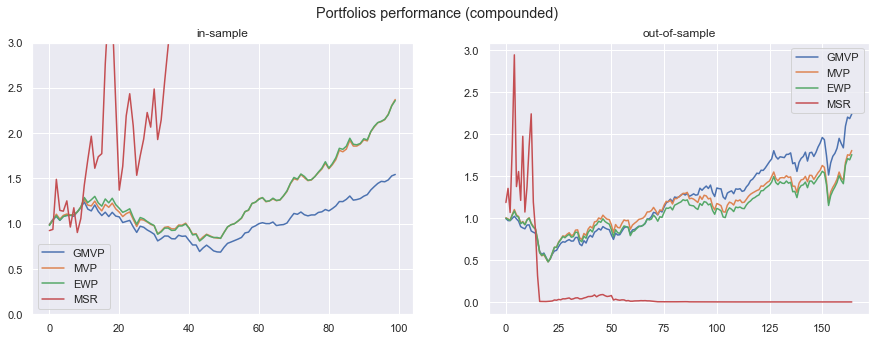

<Figure size 720x1080 with 0 Axes>

In [19]:
# zoom in on the in sample plot:

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
plt.figure(figsize=(10,15))
ax1.plot(np.array(wealth_geom_trn).T)
ax2.plot(np.array(wealth_geom_tst).T)
fig.suptitle('Portfolios performance (compounded)')
ax1.set_title("in-sample")
ax2.set_title("out-of-sample")
ax1.legend(allocation.index)
ax2.legend(allocation.index)
ax1.set(ylim=(0,3))
plt.show()

### 2. in-sample (02/1999-05/2007) 

Since MSR portfolio focuses on high return assets, the annual return of it is very high, also with the volatility and of course the sharpe ratio.\
On the other hand, the GMVP keep very low volatility, also very low return as expected.\
The MVP and EWP have similar return as the constrain that set earlier. However, since the volatility is smaller, the MVP have higher sharpe ratio than EWP.\
We will see how these portfolios perform in the out-of-sample test.


### 3. Out of sample (06/2007-02/2021)

The out-of-sample test show a lot of difference compare to in-sample.
- Compare to in-sample results, annual return of the portfolios drop while volatility increase, especially MSR which yields negatively and very high volatility.
- The annual return of GMVP is not high but actually increase compare to in-sample result.
- EWP and MVP have quite the same return volatility and sharpe ratio, although MVP is a bit better.
- We can see that the naive approach EWP show very stable result, although with this dataset, the GMVP is proven to be better. 
- We plotted the evolution of portfolio wealth above, it can be seen that MSR performs badly and have negative wealth in the out-of-sample test. GMVP perform best while EWP and MVP have quite similar but good results.

We draw some attention to the Minimum Variance portfolio which determined from convex optimization method (CVXPY) with short selling and return is set above the EWP. In this dataset, the MVP have very stable performance as EWP but better, as it optimizes the volatility better.



# PART II: Global asset allocation with currency overly

In [20]:
# Get the spot price, forward price and bond price
# We have to adjust the USD/AUD to AUD/USD to be more proper
spot = pd.read_excel("DataMonthly.xlsx", sheet_name = "Spot",index_col = 0)
spot = spot.iloc[2:,:]
spot.iloc[:,0]= 1/spot.iloc[:,0]
forward = pd.read_excel("DataMonthly.xlsx", sheet_name = "Forward",index_col = 0)
forward = forward.iloc[2:,:]
forward.iloc[:,0]= 1/forward.iloc[:,0]

In [21]:
spot.head()

,Australia,Canada,Euro area,Japan,UK,US
1999-01-29 00:00:00,1.5916,1.5107,0.88051,116.28,0.60872,1.0
1999-02-26 00:00:00,1.61031,1.5095,0.91091,118.65,0.62422,1.0
1999-03-31 00:00:00,1.58353,1.5128,0.92627,118.43,0.61946,1.0
1999-04-30 00:00:00,1.50875,1.4563,0.94518,119.365,0.62108,1.0
1999-05-31 00:00:00,1.52929,1.4719,0.9563,120.82,0.62406,1.0


In [22]:
forward.head()

,Australia,Canada,Euro area,Japan,UK,US
1999-01-29 00:00:00,1.59139,1.51083,0.87933,115.875,0.60917,1.0
1999-02-26 00:00:00,1.61002,1.50966,0.90957,118.171,0.62457,1.0
1999-03-31 00:00:00,1.58333,1.51267,0.92468,117.905,0.61966,1.0
1999-04-30 00:00:00,1.50861,1.45617,0.94334,118.876,0.6213,1.0
1999-05-31 00:00:00,1.52919,1.47162,0.95445,120.332,0.62427,1.0


In [23]:
# Calculate currency excess return or payoff from a long forward position
f = (spot.shift(1) - forward)/spot
f = f.dropna().astype(np.float32)
f.head()

,Australia,Canada,Euro area,Japan,UK,US
1999-02-26 00:00:00,-0.011442,0.000689,-0.031902,-0.015933,-0.025392,0.0
1999-03-31 00:00:00,0.017035,-0.002095,-0.014866,0.006291,0.007361,0.0
1999-04-30 00:00:00,0.049655,0.038886,-0.018060,-0.003732,-0.002963,0.0
1999-05-31 00:00:00,-0.013367,-0.010408,-0.009694,-0.008000,-0.005112,0.0
1999-06-30 00:00:00,0.012551,-0.005115,-0.011561,0.002586,-0.016110,0.0


In [28]:
print(np.std(f), np.mean(f))

Australia    0.035246
Canada       0.025182
Euro area    0.027405
Japan        0.026655
UK           0.024993
US           0.000000
dtype: float32 Australia   -0.000177
Canada       0.000909
Euro area    0.001204
Japan        0.002483
UK          -0.000585
US           0.000000
dtype: float32


Comment: 
- Japan have the highest average return while Australia and UK have negative avearage return
- AUD has the highest volatility while the rest currencies have similar volatility

In [25]:
# vector of multiple regression coefficients of the dollar portfolio stock returns on forward hedges
GMVP_unhedge = ret_equity @ allocation.iloc[0,:].T
GMVP_unhedge_trn = GMVP_unhedge.iloc[:T_trn,]
GMVP_unhedge_tst = GMVP_unhedge.iloc[T_trn:,]

# Add a residual position in the domestic riskless bond so that the portfolio weights sum to unity
Sigma_Pf = np.array([np.cov(GMVP_unhedge_trn,f[stock].iloc[:T_trn,])[0, 1] for stock in f.columns])
Sigma_ff = np.array([np.cov(f[stock].iloc[:T_trn,], f[stock].iloc[:T_trn,])[0, 0] for stock in f.columns])
w_currency = -np.array(Sigma_Pf/Sigma_ff)
w_currency[5]=0
w_currency


<ipython-input-25-3328abc82993>:9: RuntimeWarning: invalid value encountered in true_divide
  w_currency = -np.array(Sigma_Pf/Sigma_ff)


array([-0.67636369, -0.66048867, -0.18527439, -0.39750263, -0.19233455,
        0.        ])

In [26]:
# Add a residual position in the domestic riskless bond so that the portfolio weights sum to unity
w_bond = 1 - sum(w_currency)
w_bond

3.1119639400636485

In [27]:
# The hedged portfolio return equal unhedged return + currency hedge + bond yield
ret_hedged_trn = np.array(GMVP_unhedge_trn) + np.array(f.iloc[:T_trn,] @ w_currency) + np.asarray(w_bond*bond.iloc[:T_trn,]).reshape(GMVP_unhedge_trn.shape[0],)
ret_hedged_tst = np.array(GMVP_unhedge_tst) + np.array(f.iloc[T_trn:,] @ w_currency) + np.asarray(w_bond*bond.iloc[T_trn:,]).reshape(GMVP_unhedge_tst.shape[0],)
vol_hedged_trn = np.sqrt(np.var(GMVP_unhedge_trn+ w_currency @ f.iloc[:T_trn,].T))
vol_hedged_tst = np.sqrt(np.var(GMVP_unhedge_tst+ w_currency @ f.iloc[T_trn:,].T))
SR_hedged_trn = (ret_hedged_trn.mean()-rfr)/vol_hedged_trn
SR_hedged_tst = (ret_hedged_tst.mean()-rfr)/vol_hedged_tst

hedging = pd.DataFrame([[ret_hedged_trn.mean()-rfr,vol_hedged_trn,SR_hedged_trn,
                        ret_hedged_tst.mean()-rfr,vol_hedged_tst,SR_hedged_tst],
                       performance.iloc[0,:]])
hedging.index = ['Hedged GMVP','Unhedged GMVP']
hedging.columns = performance.columns

hedging

,avg excess return train,volatility train,sharpe ratio train,avg excess return test,volatility test,sharpe ratio test
Hedged GMVP,0.005424,0.037888,0.143166,0.005694,0.039975,0.142430
Unhedged GMVP,0.002230,0.036055,0.061843,0.003211,0.046366,0.069252


### 4. In-sample test - hedging MVP portfolio
Compare to the unhedged portfolio, the hedged porfolio show higher return and much lower volatility, making sharpe ratio skyrocket after hedging. This is come from shorting the foreign currency forward to lower the volatility of the portfolio and buying UST-Bill 1M at the same time. 

### 5. Out-of-sample test - hedging MVP portfolio
Using the same weight of currency forward from train dataset, the hedged porfolio also show higher return and much lower volatility, making sharpe ratio skyrocket after hedging. This is come from shorting the foreign currency forward to lower the volatility of the portfolio and buying UST-Bill 1M at the same time. 